In [1]:
import os
import numpy as np
import pandas as pd
from utilities import cal_score

In [2]:
stack_idx = '20'
models = '1-37'
use_test_kfold = set([2, 7, 8, 12, 13])

is_simple_mean = False

## Ratio files

In [3]:
df_ratios = pd.read_csv('stack_ratios.csv')
df_ratios['ratio in group'] = df_ratios['ratio in group'].fillna(0)
df_ratios['group shares'] = df_ratios['group shares'].fillna(0)
df_ratios['all ratio'] = df_ratios['ratio in group']*df_ratios['group shares']

In [4]:
df_ratios

,N,ratio in group,group shares,all ratio,name
0,1,0.00,0.00,0.0000,lgb
1,2,0.25,0.20,0.0500,keras-search
2,3,0.13,0.19,0.0247,lgb-corr-feats-selection-100
3,4,1.00,0.04,0.0400,lgb-PCA
4,5,0.00,0.00,0.0000,lgb-wo-per-area
5,6,0.00,0.00,0.0000,lgb-lr0.001
6,7,0.00,0.20,0.0000,keras-embedding
7,8,0.25,0.20,0.0500,keras-search-long
8,9,0.00,0.00,0.0000,lgb-feats-selection-75
9,10,0.13,0.19,0.0247,lgb-feats-selection-75-lr-0.001


In [5]:
df_ratios['all ratio'].sum()

1.0

In [6]:
ratios = df_ratios['all ratio'].values

In [99]:
print(ratios)

[0.     0.05   0.0247 0.04   0.     0.     0.     0.05   0.     0.0247
 0.     0.05   0.05   0.0247 0.0247 0.0247 0.0247 0.0418 0.0285 0.0285
 0.075  0.075  0.     0.04   0.0285 0.0475 0.0285 0.0285 0.     0.
 0.     0.0304 0.0304 0.0304 0.0304 0.038  0.0304]


In [8]:
len(ratios)

37

### Read CV predictions and test

In [9]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [10]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [11]:
# File candidate
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]

In [12]:
# files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}
# files_test_one = {
#     33: 'model-33-lgb-remove_outlier_03-test-one.csv',
#     35: 'model-35-lgb-remove_outlier_03-2-test-one-400000.csv',
#     36: 'model-36-lgb-remove_outlier_03-0.001-2-test-one.csv',
#     37: 'model-37-lgb-remove_outlier_05-test-one.csv',
# }

In [13]:
files_test_used = {idx: files_test_kf[idx] 
                   if idx in use_test_kfold else files_test_one[idx] 
                   for idx in idx_models}

In [14]:
files_test_used

{1: 'model-01-lgb-test-one.csv',
 2: 'model-02-keras-search-test-kfold.csv',
 3: 'model-03-lgb-feats-selection-test-one.csv',
 4: 'model-04-lgb-PCA-test-one.csv',
 5: 'model-05-lgb-wo-per-area-test-one.csv',
 6: 'model-06-lgb-lr0.001-test-one.csv',
 7: 'model-07-keras-embedding-test-kfold.csv',
 8: 'model-08-keras-search-long-test-kfold.csv',
 9: 'model-09-lgb-feats-selection-75-test-one.csv',
 10: 'model-10-lgb-feats-selection-75-lr-0.001-test-one.csv',
 11: 'model-11-rf-test-one.csv',
 12: 'model-12-predict-keras-search-prelu-test-kfold.csv',
 13: 'model-13-predict-keras-he_uni-test-kfold.csv',
 14: 'model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv',
 15: 'model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv',
 16: 'model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv',
 17: 'model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv',
 18: 'model-18-lgb-feats-selection-70-lr-0.001-p5-test-one.csv',
 19: 'model-19-lgb-search-bins-lr-0.0005-test-one.csv',
 20:

In [15]:
files_cv

{1: 'model-01-lgb-cv.csv',
 2: 'model-02-keras-search-cv.csv',
 3: 'model-03-lgb-feats-selection-cv.csv',
 4: 'model-04-lgb-PCA-cv.csv',
 5: 'model-05-lgb-wo-per-area-cv.csv',
 6: 'model-06-lgb-lr0.001-cv.csv',
 7: 'model-07-keras-embedding-cv.csv',
 8: 'model-08-keras-search-long-cv.csv',
 9: 'model-09-lgb-feats-selection-75-cv.csv',
 10: 'model-10-lgb-feats-selection-75-lr-0.001-cv.csv',
 11: 'model-11-rf-cv.csv',
 12: 'model-12-predict-keras-search-prelu-cv.csv',
 13: 'model-13-predict-keras-he_uni-cv.csv',
 14: 'model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv',
 15: 'model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv',
 16: 'model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv',
 17: 'model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv',
 18: 'model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv',
 19: 'model-19-lgb-search-bins-lr-0.0005-cv.csv',
 20: 'model-20-lgb-lr-0.0008-mix5-cv.csv',
 21: 'model-21-lgb-wo-per-area-long-cv.csv',
 22: 'model-22-lgb-wo-per-area-long-2-cv

In [16]:
# Prediction test set
dfs = [pd.read_csv('output/'+f).rename({'total_price': 'pred_'+str(i)}, axis=1) 
       for i, f in files_test_used.items()]
df = dfs[0]
for df_i in dfs[1:]:
    df = df.merge(df_i, on='building_id', how='inner')

cols_pred = ['pred_'+str(i) for i in files_test_used]
print(cols_pred)

['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9', 'pred_10', 'pred_11', 'pred_12', 'pred_13', 'pred_14', 'pred_15', 'pred_16', 'pred_17', 'pred_18', 'pred_19', 'pred_20', 'pred_21', 'pred_22', 'pred_23', 'pred_24', 'pred_25', 'pred_26', 'pred_27', 'pred_28', 'pred_29', 'pred_30', 'pred_31', 'pred_32', 'pred_33', 'pred_34', 'pred_35', 'pred_36', 'pred_37']


In [105]:
# Prediction from kfold test set
df_kfoldss = [pd.read_csv('output/'+f).rename({'total_price': 'pred_'+str(i)}, axis=1) 
       for i, f in files_test_kf.items()]
df_kfolds = df_kfoldss[0]
for df_i in df_kfoldss[1:]:
    df_kfolds = df_kfolds.merge(df_i, on='building_id', how='inner')

In [81]:
# Train CV set
cvs = [pd.read_csv('output/'+f)
       [['building_id', 'total_price_predict']]
       .rename({'total_price_predict': 'pred_'+str(i)}, axis=1)
       for i, f in files_cv.items()]
cv = cvs[0]
for df_i in cvs[1:]:
    cv = cv.merge(df_i, on='building_id', how='inner')

In [18]:
df.check()

,building_id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37
0,X5gsdTWGS3W7JJQB,1.526912e+07,12470072.0,1.531685e+07,1.162534e+07,1.291407e+07,1.440081e+07,14753138.0,12899050.0,1.468227e+07,...,1.485198e+07,1.458851e+07,1.341823e+07,1.235658e+07,1.301152e+07,1.334910e+07,1.265085e+07,1.313244e+07,1.298618e+07,1.304845e+07
1,BTshNOJyKHnT2YIT,3.924241e+06,3916552.2,3.977095e+06,4.000835e+06,3.926993e+06,3.957502e+06,3797768.8,3933929.2,3.899813e+06,...,3.925095e+06,3.930381e+06,3.931973e+06,3.933268e+06,3.894991e+06,3.890587e+06,3.890897e+06,3.896216e+06,3.897411e+06,3.897545e+06
2,dhdymr0lV8N5kZOT,1.096127e+07,11912735.0,1.084967e+07,1.232111e+07,1.136213e+07,1.095060e+07,11465174.0,11718318.0,1.118557e+07,...,1.066340e+07,1.053625e+07,1.221239e+07,1.039900e+07,1.080365e+07,1.059390e+07,1.078313e+07,1.078764e+07,1.049745e+07,1.035078e+07
3,VEwyGGMcD56w5BOc,6.155550e+06,5940670.0,6.015238e+06,5.991010e+06,5.832794e+06,6.042104e+06,6112098.0,5997081.0,6.070453e+06,...,6.025775e+06,5.922934e+06,5.957837e+06,5.944207e+06,6.041281e+06,6.119229e+06,6.080412e+06,6.102227e+06,6.139949e+06,6.120593e+06
4,wmUeMoJZfsqaSX9b,1.062995e+06,1088488.1,1.027248e+06,1.129552e+06,1.031193e+06,1.056516e+06,1039337.0,1074525.1,1.050322e+06,...,1.078927e+06,1.092658e+06,1.110080e+06,1.140621e+06,1.088976e+06,1.110317e+06,1.092040e+06,1.104233e+06,1.106728e+06,1.098338e+06
9995,UEeCDaAJzPwdKKKA,1.236424e+06,1260086.6,1.242342e+06,1.215484e+06,1.302444e+06,1.219529e+06,1184220.1,1259012.6,1.243055e+06,...,1.201942e+06,1.204832e+06,1.240022e+06,1.204761e+06,1.202680e+06,1.181563e+06,1.205432e+06,1.191904e+06,1.191593e+06,1.175668e+06
9996,i0fgbPaQsDWs7Q87,4.916930e+07,45092864.0,4.936848e+07,4.976593e+07,4.432514e+07,4.900936e+07,46319644.0,44976560.0,4.791654e+07,...,4.878625e+07,4.868407e+07,4.878002e+07,4.874787e+07,4.837705e+07,4.817584e+07,4.803908e+07,4.858715e+07,4.826300e+07,4.830921e+07
9997,YunNwAhcqkf6YclI,1.079340e+06,1126697.4,1.068873e+06,1.099709e+06,1.121440e+06,1.088698e+06,1065270.2,1161924.1,1.081569e+06,...,1.103150e+06,1.102001e+06,1.154029e+06,1.142251e+06,1.086812e+06,1.094032e+06,1.089606e+06,1.108525e+06,1.114377e+06,1.142751e+06
9998,A2NotxtRY9MYoWMl,2.982601e+06,3133222.2,2.951807e+06,2.989147e+06,2.969693e+06,2.933954e+06,2984613.5,3097389.5,2.943919e+06,...,2.981641e+06,2.971377e+06,2.908844e+06,2.991432e+06,2.950951e+06,2.970882e+06,2.962959e+06,2.962741e+06,2.973267e+06,2.933060e+06
9999,kKvgBXiA50gRmQhP,3.126599e+06,3056341.5,3.159099e+06,3.373994e+06,2.794585e+06,3.178000e+06,2868098.5,3323556.2,3.121264e+06,...,3.082835e+06,3.115415e+06,3.111033e+06,3.178325e+06,3.124670e+06,3.129095e+06,3.111042e+06,3.118331e+06,3.102721e+06,3.067082e+06


shape = (10000, 38)


In [106]:
df_kfolds.check()

,building_id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37
0,X5gsdTWGS3W7JJQB,1.334850e+07,12470072.0,1.373257e+07,1.114907e+07,1.251766e+07,1.363086e+07,14753138.0,12899050.0,1.382834e+07,...,1.390580e+07,1.383135e+07,1.312068e+07,1.206594e+07,1.248089e+07,1.294552e+07,1.237451e+07,1.274310e+07,1.258175e+07,1.251122e+07
1,BTshNOJyKHnT2YIT,3.936837e+06,3916552.2,3.925769e+06,3.976751e+06,3.908412e+06,3.943782e+06,3797768.8,3933929.2,3.938209e+06,...,3.915159e+06,3.940074e+06,3.930393e+06,3.927043e+06,3.888208e+06,3.890653e+06,3.897657e+06,3.896304e+06,3.893664e+06,3.886369e+06
2,dhdymr0lV8N5kZOT,1.078718e+07,11912735.0,1.070633e+07,1.242211e+07,1.134703e+07,1.090404e+07,11465174.0,11718318.0,1.081063e+07,...,1.060384e+07,1.051579e+07,1.218141e+07,1.003854e+07,1.056769e+07,1.043973e+07,1.068488e+07,1.039138e+07,1.037722e+07,1.029499e+07
3,VEwyGGMcD56w5BOc,6.006376e+06,5940670.0,5.981772e+06,5.884823e+06,5.729979e+06,6.014364e+06,6112098.0,5997081.0,6.048971e+06,...,5.950293e+06,5.887888e+06,5.944541e+06,5.950882e+06,5.999361e+06,6.031425e+06,5.989918e+06,6.073522e+06,6.087771e+06,6.064761e+06
4,wmUeMoJZfsqaSX9b,1.062499e+06,1088488.1,1.087321e+06,1.123973e+06,9.856155e+05,1.064778e+06,1039337.0,1074525.1,1.045366e+06,...,1.101185e+06,1.088088e+06,1.116792e+06,1.132476e+06,1.092417e+06,1.096440e+06,1.092912e+06,1.089292e+06,1.086393e+06,1.089657e+06
9995,UEeCDaAJzPwdKKKA,1.230824e+06,1260086.6,1.247061e+06,1.214291e+06,1.291997e+06,1.229866e+06,1184220.1,1259012.6,1.217540e+06,...,1.223818e+06,1.219536e+06,1.249674e+06,1.227599e+06,1.216996e+06,1.201292e+06,1.216232e+06,1.205777e+06,1.205263e+06,1.198050e+06
9996,i0fgbPaQsDWs7Q87,4.823185e+07,45092864.0,4.833738e+07,4.835621e+07,4.417096e+07,4.797663e+07,46319644.0,44976560.0,4.716411e+07,...,4.733128e+07,4.778303e+07,4.684310e+07,4.759461e+07,4.691685e+07,4.722399e+07,4.728982e+07,4.684609e+07,4.701567e+07,4.738786e+07
9997,YunNwAhcqkf6YclI,1.074593e+06,1126697.4,1.078869e+06,1.099118e+06,1.094910e+06,1.073270e+06,1065270.2,1161924.1,1.068452e+06,...,1.083343e+06,1.083037e+06,1.127559e+06,1.128214e+06,1.077722e+06,1.083880e+06,1.076041e+06,1.099187e+06,1.103091e+06,1.131617e+06
9998,A2NotxtRY9MYoWMl,2.975346e+06,3133222.2,2.961775e+06,3.054271e+06,2.962259e+06,2.953246e+06,2984613.5,3097389.5,2.967009e+06,...,2.958952e+06,2.962168e+06,2.958519e+06,2.966948e+06,2.951865e+06,2.955389e+06,2.953318e+06,2.981540e+06,2.989137e+06,2.937790e+06
9999,kKvgBXiA50gRmQhP,3.149033e+06,3056341.5,3.181764e+06,3.354956e+06,2.876777e+06,3.165120e+06,2868098.5,3323556.2,3.179176e+06,...,3.116548e+06,3.134399e+06,3.096989e+06,3.142961e+06,3.101369e+06,3.113092e+06,3.093144e+06,3.105885e+06,3.075519e+06,3.085499e+06


shape = (10000, 38)


In [19]:
assert not (df == 0).any().any()

# to log
for c in cols_pred:
    df['log_'+c] = np.log(df[c])
cols_log_pred = ['log_'+c for c in cols_pred]
print(cols_log_pred)

['log_pred_1', 'log_pred_2', 'log_pred_3', 'log_pred_4', 'log_pred_5', 'log_pred_6', 'log_pred_7', 'log_pred_8', 'log_pred_9', 'log_pred_10', 'log_pred_11', 'log_pred_12', 'log_pred_13', 'log_pred_14', 'log_pred_15', 'log_pred_16', 'log_pred_17', 'log_pred_18', 'log_pred_19', 'log_pred_20', 'log_pred_21', 'log_pred_22', 'log_pred_23', 'log_pred_24', 'log_pred_25', 'log_pred_26', 'log_pred_27', 'log_pred_28', 'log_pred_29', 'log_pred_30', 'log_pred_31', 'log_pred_32', 'log_pred_33', 'log_pred_34', 'log_pred_35', 'log_pred_36', 'log_pred_37']


In [82]:
assert not (cv == 0).any().any()

# to log
for c in cols_pred:
    cv['log_'+c] = np.log(cv[c])

In [107]:
assert not (df_kfolds == 0).any().any()

# to log
for c in cols_pred:
    df_kfolds['log_'+c] = np.log(df_kfolds[c])

In [21]:
if is_simple_mean:
    # Simple mean
    df['log_total_price'] = df.loc[:, cols_log_pred].mean(axis=1)
else:
    # Selected ratio
    df['log_total_price'] = df.loc[:, cols_log_pred].dot(ratios)
df['total_price'] = np.exp(df['log_total_price'])

In [83]:
if is_simple_mean:
    # Simple mean
    cv['log_total_price'] = cv.loc[:, cols_log_pred].mean(axis=1)
else:
    # Selected ratio
    cv['log_total_price'] = cv.loc[:, cols_log_pred].dot(ratios)
cv['total_price'] = np.exp(cv['log_total_price'])

In [108]:
if is_simple_mean:
    # Simple mean
    df_kfolds['log_total_price'] = df_kfolds.loc[:, cols_log_pred].mean(axis=1)
else:
    # Selected ratio
    df_kfolds['log_total_price'] = df_kfolds.loc[:, cols_log_pred].dot(ratios)
df_kfolds['total_price'] = np.exp(df_kfolds['log_total_price'])

In [23]:
df.check()

,building_id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,log_pred_30,log_pred_31,log_pred_32,log_pred_33,log_pred_34,log_pred_35,log_pred_36,log_pred_37,log_total_price,total_price
0,X5gsdTWGS3W7JJQB,1.526912e+07,12470072.0,1.531685e+07,1.162534e+07,1.291407e+07,1.440081e+07,14753138.0,12899050.0,1.468227e+07,...,16.412125,16.329699,16.381346,16.406960,16.353235,16.390596,16.379396,16.384180,16.400737,1.326629e+07
1,BTshNOJyKHnT2YIT,3.924241e+06,3916552.2,3.977095e+06,4.000835e+06,3.926993e+06,3.957502e+06,3797768.8,3933929.2,3.899813e+06,...,15.184652,15.184981,15.175202,15.174070,15.174150,15.175516,15.175823,15.175857,15.181609,3.920028e+06
2,dhdymr0lV8N5kZOT,1.096127e+07,11912735.0,1.084967e+07,1.232111e+07,1.136213e+07,1.095060e+07,11465174.0,11718318.0,1.118557e+07,...,16.317962,16.157220,16.195394,16.175789,16.193493,16.193911,16.166643,16.152573,16.221399,1.108828e+07
3,VEwyGGMcD56w5BOc,6.155550e+06,5940670.0,6.015238e+06,5.991010e+06,5.832794e+06,6.042104e+06,6112098.0,5997081.0,6.070453e+06,...,15.600218,15.597928,15.614127,15.626947,15.620583,15.624164,15.630327,15.627169,15.604895,5.985768e+06
4,wmUeMoJZfsqaSX9b,1.062995e+06,1088488.1,1.027248e+06,1.129552e+06,1.031193e+06,1.056516e+06,1039337.0,1074525.1,1.050322e+06,...,13.919943,13.947083,13.900748,13.920156,13.903558,13.914661,13.916918,13.909309,13.884521,1.071447e+06
9995,UEeCDaAJzPwdKKKA,1.236424e+06,1260086.6,1.242342e+06,1.215484e+06,1.302444e+06,1.219529e+06,1184220.1,1259012.6,1.243055e+06,...,14.030640,14.001792,14.000063,13.982349,14.002349,13.991063,13.990802,13.977347,14.020795,1.227875e+06
9996,i0fgbPaQsDWs7Q87,4.916930e+07,45092864.0,4.936848e+07,4.976593e+07,4.432514e+07,4.900936e+07,46319644.0,44976560.0,4.791654e+07,...,17.702831,17.702172,17.694536,17.690368,17.687525,17.698870,17.692176,17.693133,17.665733,4.700353e+07
9997,YunNwAhcqkf6YclI,1.079340e+06,1126697.4,1.068873e+06,1.099709e+06,1.121440e+06,1.088698e+06,1065270.2,1161924.1,1.081569e+06,...,13.958770,13.948511,13.898760,13.905380,13.901327,13.918541,13.923806,13.948949,13.914058,1.103567e+06
9998,A2NotxtRY9MYoWMl,2.982601e+06,3133222.2,2.951807e+06,2.989147e+06,2.969693e+06,2.933954e+06,2984613.5,3097389.5,2.943919e+06,...,14.883266,14.911263,14.897638,14.904369,14.901699,14.901625,14.905172,14.891557,14.912381,2.994778e+06
9999,kKvgBXiA50gRmQhP,3.126599e+06,3056341.5,3.159099e+06,3.373994e+06,2.794585e+06,3.178000e+06,2868098.5,3323556.2,3.121264e+06,...,14.950465,14.971865,14.954839,14.956254,14.950468,14.952809,14.947790,14.936237,14.951405,3.113957e+06


shape = (10000, 77)


In [109]:
df_kfolds.check()

,building_id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,log_pred_30,log_pred_31,log_pred_32,log_pred_33,log_pred_34,log_pred_35,log_pred_36,log_pred_37,log_total_price,total_price
0,X5gsdTWGS3W7JJQB,1.334850e+07,12470072.0,1.373257e+07,1.114907e+07,1.251766e+07,1.363086e+07,14753138.0,12899050.0,1.382834e+07,...,16.389700,16.305897,16.339709,16.376260,16.331149,16.360500,16.347758,16.342136,16.369563,1.285910e+07
1,BTshNOJyKHnT2YIT,3.936837e+06,3916552.2,3.925769e+06,3.976751e+06,3.908412e+06,3.943782e+06,3797768.8,3933929.2,3.938209e+06,...,15.184250,15.183397,15.173459,15.174088,15.175886,15.175539,15.174861,15.172986,15.180460,3.915524e+06
2,dhdymr0lV8N5kZOT,1.078718e+07,11912735.0,1.070633e+07,1.242211e+07,1.134703e+07,1.090404e+07,11465174.0,11718318.0,1.081063e+07,...,16.315422,16.121942,16.173312,16.161129,16.184340,16.156488,16.155124,16.147168,16.218456,1.105569e+07
3,VEwyGGMcD56w5BOc,6.006376e+06,5940670.0,5.981772e+06,5.884823e+06,5.729979e+06,6.014364e+06,6112098.0,5997081.0,6.048971e+06,...,15.597984,15.599050,15.607164,15.612494,15.605588,15.619449,15.621793,15.618006,15.598498,5.947595e+06
4,wmUeMoJZfsqaSX9b,1.062499e+06,1088488.1,1.087321e+06,1.123973e+06,9.856155e+05,1.064778e+06,1039337.0,1074525.1,1.045366e+06,...,13.925971,13.939917,13.903903,13.907579,13.904356,13.901039,13.898373,13.901374,13.885525,1.072523e+06
9995,UEeCDaAJzPwdKKKA,1.230824e+06,1260086.6,1.247061e+06,1.214291e+06,1.291997e+06,1.229866e+06,1184220.1,1259012.6,1.217540e+06,...,14.038393,14.020571,14.011896,13.998908,14.011269,14.002634,14.002208,13.996206,14.029520,1.238635e+06
9996,i0fgbPaQsDWs7Q87,4.823185e+07,45092864.0,4.833738e+07,4.835621e+07,4.417096e+07,4.797663e+07,46319644.0,44976560.0,4.716411e+07,...,17.662314,17.678230,17.663888,17.670413,17.671806,17.662378,17.665991,17.673877,17.650746,4.630434e+07
9997,YunNwAhcqkf6YclI,1.074593e+06,1126697.4,1.078869e+06,1.099118e+06,1.094910e+06,1.073270e+06,1065270.2,1161924.1,1.068452e+06,...,13.935566,13.936146,13.890360,13.896058,13.888799,13.910081,13.913627,13.939159,13.906851,1.095642e+06
9998,A2NotxtRY9MYoWMl,2.975346e+06,3133222.2,2.961775e+06,3.054271e+06,2.962259e+06,2.953246e+06,2984613.5,3097389.5,2.967009e+06,...,14.900199,14.903044,14.897948,14.899141,14.898440,14.907950,14.910495,14.893168,14.912607,2.995456e+06
9999,kKvgBXiA50gRmQhP,3.149033e+06,3056341.5,3.181764e+06,3.354956e+06,2.876777e+06,3.165120e+06,2868098.5,3323556.2,3.179176e+06,...,14.945941,14.960676,14.947354,14.951127,14.944699,14.948809,14.938984,14.942224,14.953741,3.121240e+06


shape = (10000, 77)


In [24]:
df[['building_id', 'total_price']].check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.326629e+07
1,BTshNOJyKHnT2YIT,3.920028e+06
2,dhdymr0lV8N5kZOT,1.108828e+07
3,VEwyGGMcD56w5BOc,5.985768e+06
4,wmUeMoJZfsqaSX9b,1.071447e+06
9995,UEeCDaAJzPwdKKKA,1.227875e+06
9996,i0fgbPaQsDWs7Q87,4.700353e+07
9997,YunNwAhcqkf6YclI,1.103567e+06
9998,A2NotxtRY9MYoWMl,2.994778e+06
9999,kKvgBXiA50gRmQhP,3.113957e+06


shape = (10000, 2)


In [25]:
# Output
output_filename = 'output/stack_meanlog_selected_ratios_{}_{}.csv'.format(stack_idx, models)
print('Output file to:', output_filename)

Output file to: output/stack_meanlog_selected_ratios_20_1-37.csv


In [26]:
df[['building_id', 'total_price']].to_csv(output_filename, index=False)

In [110]:
# Output
output_filename_kf = 'output/stack_meanlog_selected_ratios_{}_{}_kf.csv'.format(stack_idx, models)
print('Output file to:', output_filename_kf)

Output file to: output/stack_meanlog_selected_ratios_20_1-37_kf.csv


In [111]:
df_kfolds[['building_id', 'total_price']].to_csv(output_filename_kf, index=False)

In [27]:
# Check null
df.isnull().any()

building_id        False
pred_1             False
pred_2             False
pred_3             False
pred_4             False
pred_5             False
pred_6             False
pred_7             False
pred_8             False
pred_9             False
pred_10            False
pred_11            False
pred_12            False
pred_13            False
pred_14            False
pred_15            False
pred_16            False
pred_17            False
pred_18            False
pred_19            False
pred_20            False
pred_21            False
pred_22            False
pred_23            False
pred_24            False
pred_25            False
pred_26            False
pred_27            False
pred_28            False
pred_29            False
                   ...  
log_pred_10        False
log_pred_11        False
log_pred_12        False
log_pred_13        False
log_pred_14        False
log_pred_15        False
log_pred_16        False
log_pred_17        False
log_pred_18        False


In [112]:
# Check null
df_kfolds.isnull().any()

building_id        False
pred_1             False
pred_2             False
pred_3             False
pred_4             False
pred_5             False
pred_6             False
pred_7             False
pred_8             False
pred_9             False
pred_10            False
pred_11            False
pred_12            False
pred_13            False
pred_14            False
pred_15            False
pred_16            False
pred_17            False
pred_18            False
pred_19            False
pred_20            False
pred_21            False
pred_22            False
pred_23            False
pred_24            False
pred_25            False
pred_26            False
pred_27            False
pred_28            False
pred_29            False
                   ...  
log_pred_10        False
log_pred_11        False
log_pred_12        False
log_pred_13        False
log_pred_14        False
log_pred_15        False
log_pred_16        False
log_pred_17        False
log_pred_18        False


In [85]:
cv.isnull().any().any()

False

### CV scores

In [86]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [87]:
df_test = df_test.merge(df, on='building_id', how='inner')

In [113]:
df_test_kf = pd.read_csv('dataset/test.csv').merge(df_kfolds, on='building_id', how='inner')

In [88]:
df_train['total_price'].describe()

count    6.000000e+04
mean     1.293727e+07
std      5.522463e+07
min      2.261495e+05
25%      2.433114e+06
50%      5.240482e+06
75%      1.123932e+07
max      5.088279e+09
Name: total_price, dtype: float64

In [89]:
df_test['total_price'].describe()

count    1.000000e+04
mean     1.270705e+07
std      4.800146e+07
min      2.115926e+05
25%      2.445173e+06
50%      5.143515e+06
75%      1.077776e+07
max      2.093873e+09
Name: total_price, dtype: float64

In [114]:
df_test_kf['total_price'].describe()

count    1.000000e+04
mean     1.265161e+07
std      4.747292e+07
min      2.151663e+05
25%      2.444562e+06
50%      5.132683e+06
75%      1.074742e+07
max      2.011771e+09
Name: total_price, dtype: float64

In [90]:
df_train['log_total_price'] = np.log(df_train['total_price'])
df_train['parea_total_price'] = df_train['total_price'] / df_train['building_area']
df_train['log_parea_total_price'] = np.log(df_train['parea_total_price'])

In [91]:
df_train_cv = cv[['building_id', 'total_price']].copy()

In [92]:
df_train_cv = df_train_cv.rename({'total_price': 'total_price_pred'}, axis=1)

In [93]:
df_train = df_train.merge(df_train_cv, on='building_id', how='inner')

In [94]:
df_train.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,log_total_price,parea_total_price,log_parea_total_price,total_price_pred
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,2483,1,6011,1,34.469803,6.476038e+05,13.381034,1.894589e+05,12.151927,6.614154e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,15872,1,32221,1,40.073573,3.321452e+06,15.015913,8.218753e+05,13.619344,3.092846e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,15760,1,32228,1,54.462081,9.570885e+06,16.074236,1.713898e+06,14.354281,9.771470e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,2568,1,7271,1,99.628966,1.421501e+07,16.469809,1.048070e+06,13.862461,1.274137e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,2587,1,7442,1,124.131236,7.627120e+05,13.544636,1.626908e+05,11.999607,1.203655e+06
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,1435,1,4611,1,145.279670,9.870214e+05,13.802447,1.461375e+05,11.892303,1.411572e+06
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738412,...,5659,1,22826,1,18.814998,1.572522e+07,16.570777,2.935570e+06,14.892412,1.485844e+07
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,13252,1,32687,1,94.799593,1.181540e+07,16.284914,1.436760e+06,14.177901,1.258808e+07
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,5317,1,21087,1,33.104580,1.808500e+07,16.710593,2.071998e+06,14.544024,1.730833e+07
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,15417,1,32826,1,47.509876,8.510296e+06,15.956787,1.588694e+06,14.278423,8.130258e+06


shape = (60000, 239)


In [95]:
cal_score(df_train['total_price'], df_train['total_price_pred'])

5970.876127082137

### Compare distribution

In [74]:
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


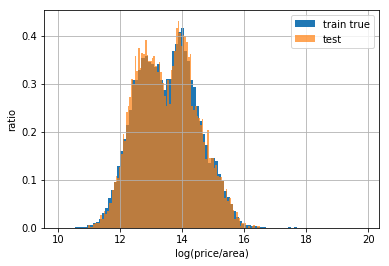

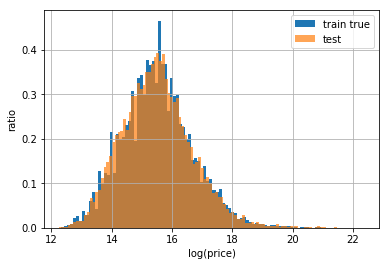

In [75]:
plt.hist(df_train['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log(df_test['total_price'] / df_test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(df_train['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log(df_test['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


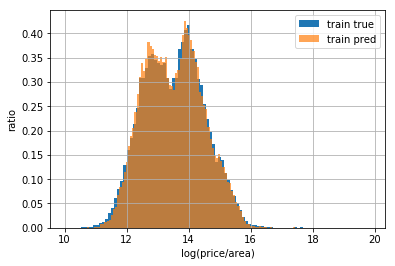

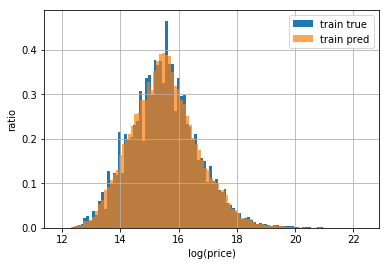

In [96]:
plt.hist(df_train['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log(df_train['total_price_pred'] / df_train['building_area']), bins=100, label='train pred',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(df_train['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log(df_train['total_price_pred']), bins=100, label='train pred', normed=True, alpha=0.7)
plt.xlabel('log(price)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


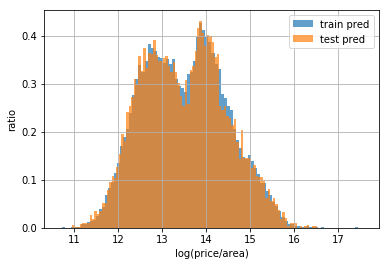

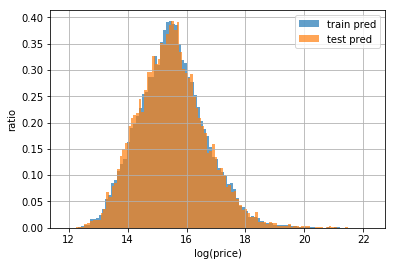

In [98]:
plt.hist(np.log(df_train['total_price_pred'] / df_train['building_area']), bins=100, label='train pred',
         normed=True, alpha=0.7)
plt.hist(np.log(df_test['total_price'] / df_test['building_area']), bins=100, label='test pred',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(np.log(df_train['total_price_pred']), bins=100, label='train pred', normed=True, alpha=0.7)
plt.hist(np.log(df_test['total_price']), bins=100, label='test pred', normed=True, alpha=0.7)
plt.xlabel('log(price)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


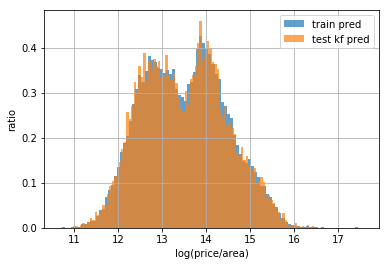

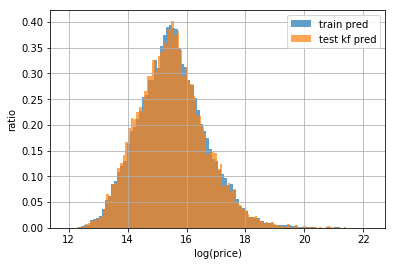

In [115]:
plt.hist(np.log(df_train['total_price_pred'] / df_train['building_area']), bins=100, label='train pred',
         normed=True, alpha=0.7)
plt.hist(np.log(df_test_kf['total_price'] / df_test_kf['building_area']), bins=100, label='test kf pred',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(np.log(df_train['total_price_pred']), bins=100, label='train pred', normed=True, alpha=0.7)
plt.hist(np.log(df_test_kf['total_price']), bins=100, label='test kf pred', normed=True, alpha=0.7)
plt.xlabel('log(price)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

In [100]:
df.check()

,building_id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,log_pred_30,log_pred_31,log_pred_32,log_pred_33,log_pred_34,log_pred_35,log_pred_36,log_pred_37,log_total_price,total_price
0,X5gsdTWGS3W7JJQB,1.526912e+07,12470072.0,1.531685e+07,1.162534e+07,1.291407e+07,1.440081e+07,14753138.0,12899050.0,1.468227e+07,...,16.412125,16.329699,16.381346,16.406960,16.353235,16.390596,16.379396,16.384180,16.400737,1.326629e+07
1,BTshNOJyKHnT2YIT,3.924241e+06,3916552.2,3.977095e+06,4.000835e+06,3.926993e+06,3.957502e+06,3797768.8,3933929.2,3.899813e+06,...,15.184652,15.184981,15.175202,15.174070,15.174150,15.175516,15.175823,15.175857,15.181609,3.920028e+06
2,dhdymr0lV8N5kZOT,1.096127e+07,11912735.0,1.084967e+07,1.232111e+07,1.136213e+07,1.095060e+07,11465174.0,11718318.0,1.118557e+07,...,16.317962,16.157220,16.195394,16.175789,16.193493,16.193911,16.166643,16.152573,16.221399,1.108828e+07
3,VEwyGGMcD56w5BOc,6.155550e+06,5940670.0,6.015238e+06,5.991010e+06,5.832794e+06,6.042104e+06,6112098.0,5997081.0,6.070453e+06,...,15.600218,15.597928,15.614127,15.626947,15.620583,15.624164,15.630327,15.627169,15.604895,5.985768e+06
4,wmUeMoJZfsqaSX9b,1.062995e+06,1088488.1,1.027248e+06,1.129552e+06,1.031193e+06,1.056516e+06,1039337.0,1074525.1,1.050322e+06,...,13.919943,13.947083,13.900748,13.920156,13.903558,13.914661,13.916918,13.909309,13.884521,1.071447e+06
9995,UEeCDaAJzPwdKKKA,1.236424e+06,1260086.6,1.242342e+06,1.215484e+06,1.302444e+06,1.219529e+06,1184220.1,1259012.6,1.243055e+06,...,14.030640,14.001792,14.000063,13.982349,14.002349,13.991063,13.990802,13.977347,14.020795,1.227875e+06
9996,i0fgbPaQsDWs7Q87,4.916930e+07,45092864.0,4.936848e+07,4.976593e+07,4.432514e+07,4.900936e+07,46319644.0,44976560.0,4.791654e+07,...,17.702831,17.702172,17.694536,17.690368,17.687525,17.698870,17.692176,17.693133,17.665733,4.700353e+07
9997,YunNwAhcqkf6YclI,1.079340e+06,1126697.4,1.068873e+06,1.099709e+06,1.121440e+06,1.088698e+06,1065270.2,1161924.1,1.081569e+06,...,13.958770,13.948511,13.898760,13.905380,13.901327,13.918541,13.923806,13.948949,13.914058,1.103567e+06
9998,A2NotxtRY9MYoWMl,2.982601e+06,3133222.2,2.951807e+06,2.989147e+06,2.969693e+06,2.933954e+06,2984613.5,3097389.5,2.943919e+06,...,14.883266,14.911263,14.897638,14.904369,14.901699,14.901625,14.905172,14.891557,14.912381,2.994778e+06
9999,kKvgBXiA50gRmQhP,3.126599e+06,3056341.5,3.159099e+06,3.373994e+06,2.794585e+06,3.178000e+06,2868098.5,3323556.2,3.121264e+06,...,14.950465,14.971865,14.954839,14.956254,14.950468,14.952809,14.947790,14.936237,14.951405,3.113957e+06


shape = (10000, 77)


In [101]:
df_test_fold = df.merge(df_test[['building_id', 'building_area']], on='building_id')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


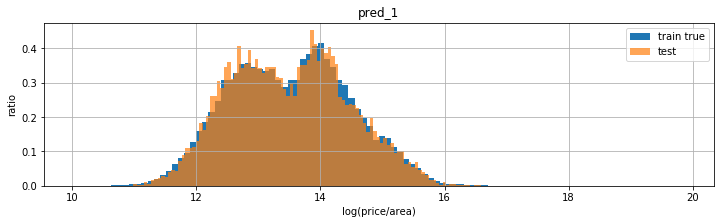

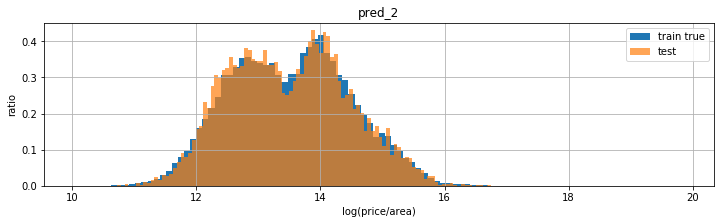

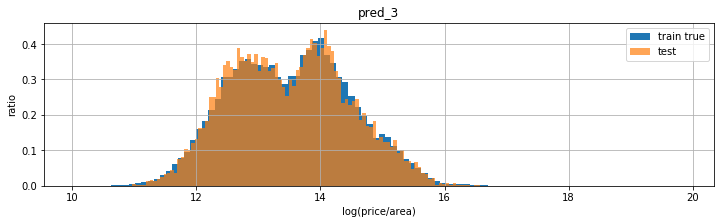

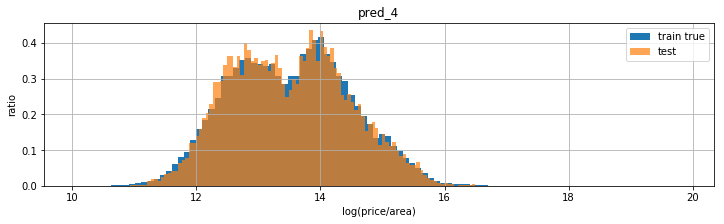

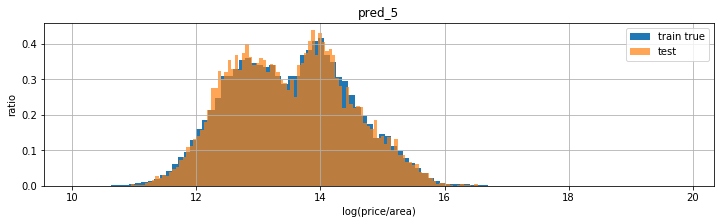

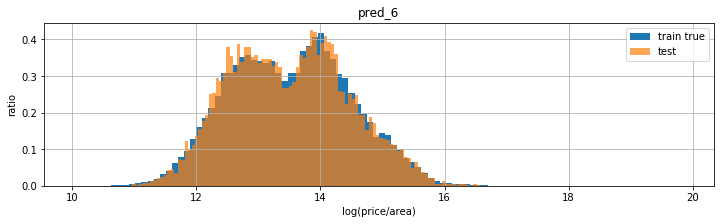

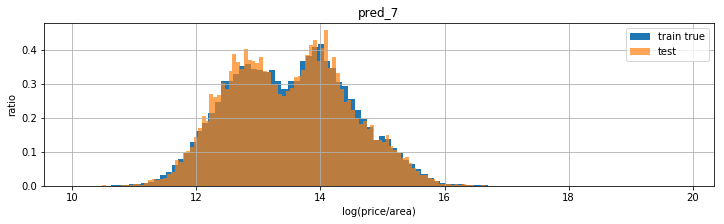

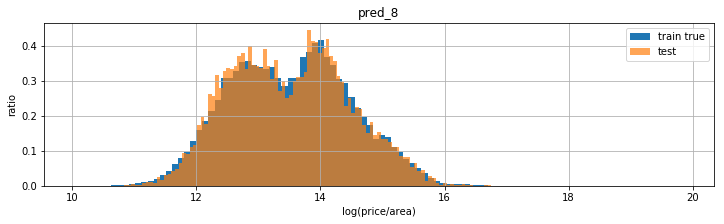

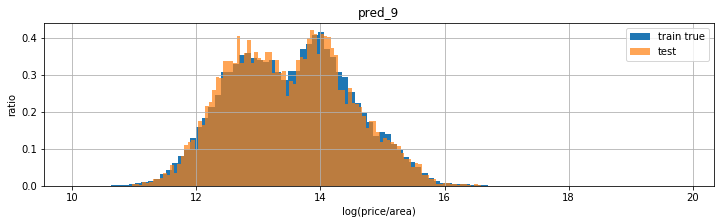

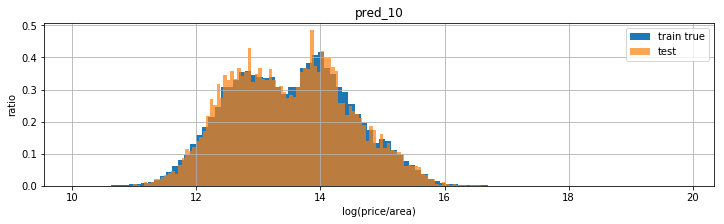

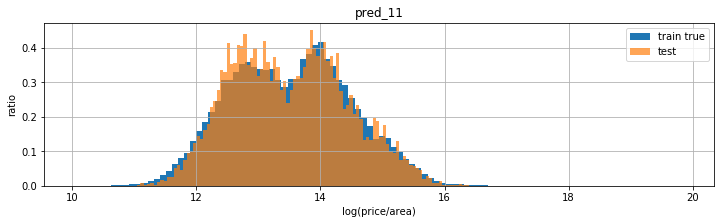

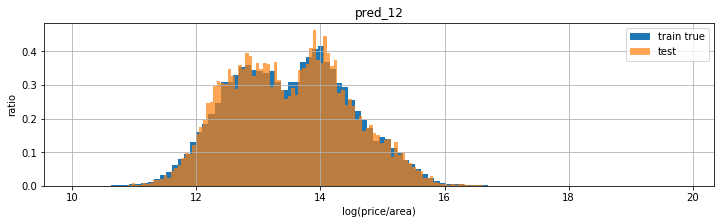

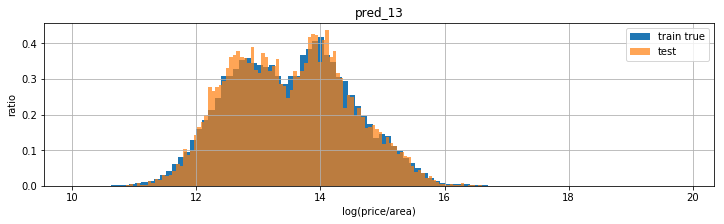

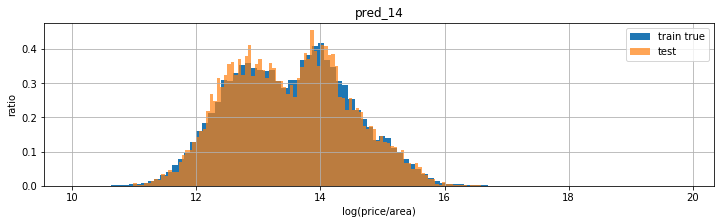

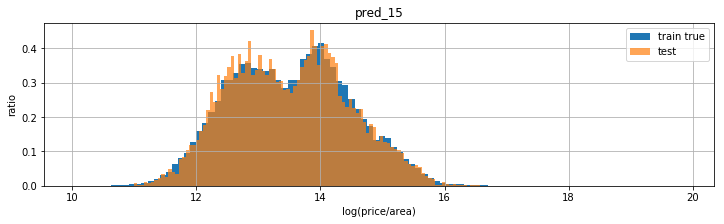

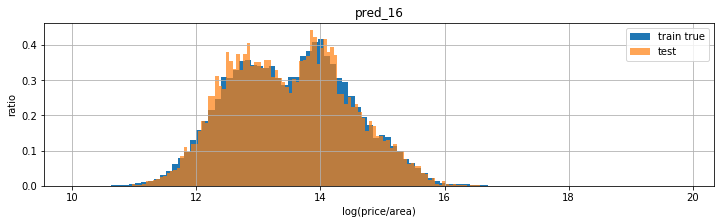

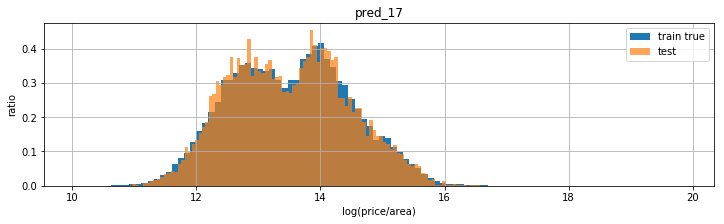

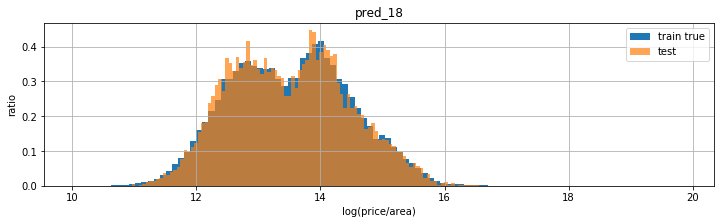

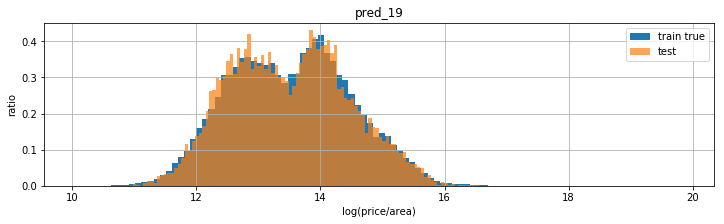

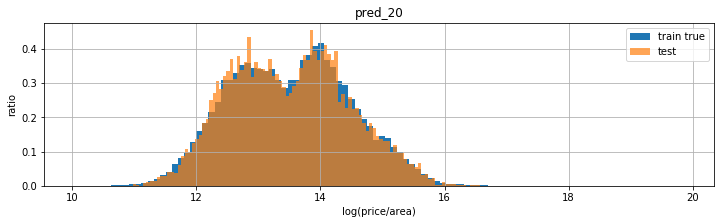

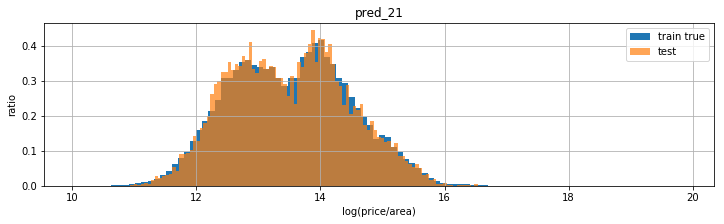

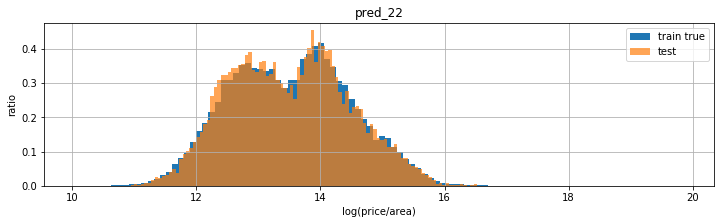

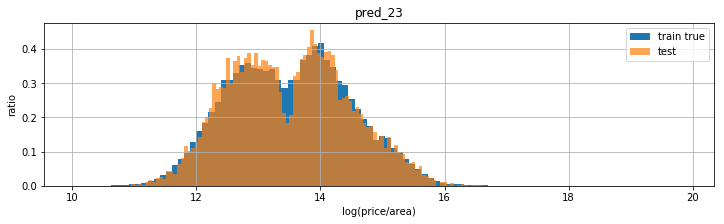

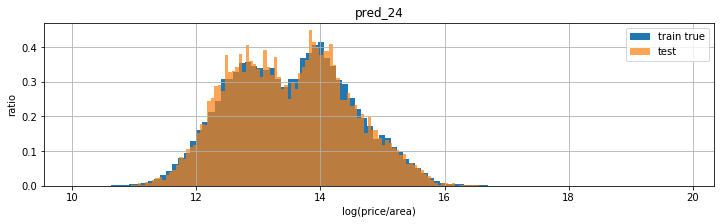

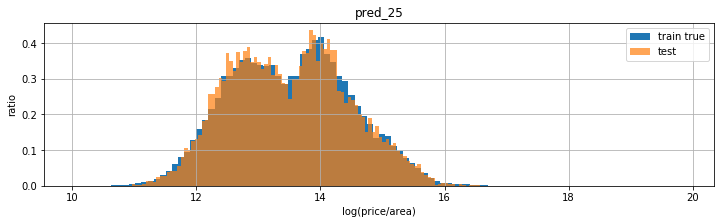

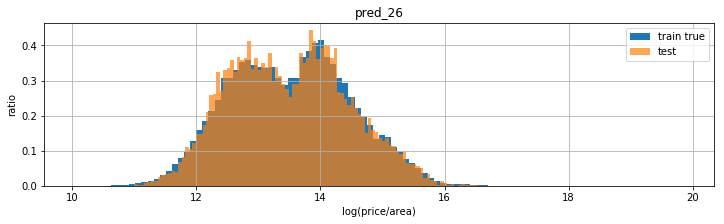

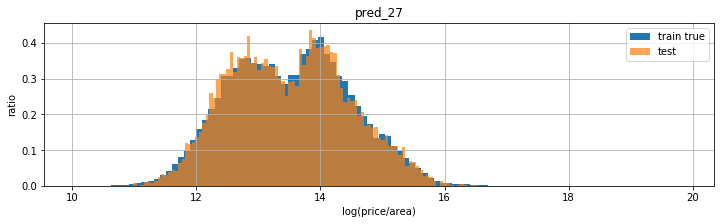

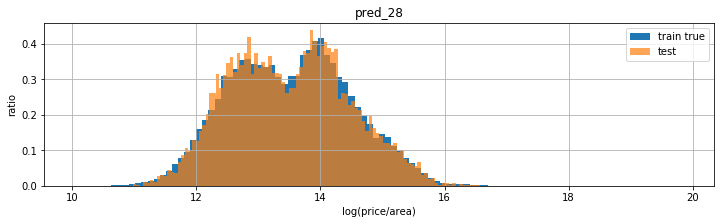

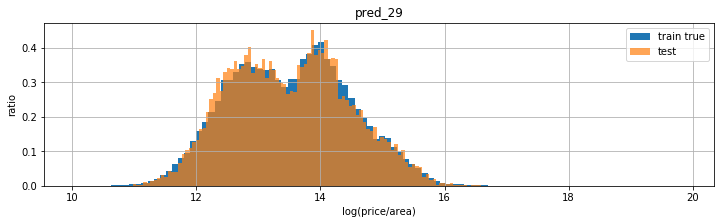

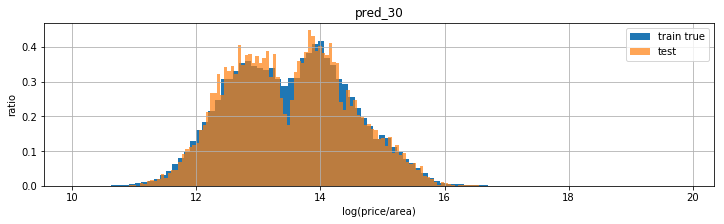

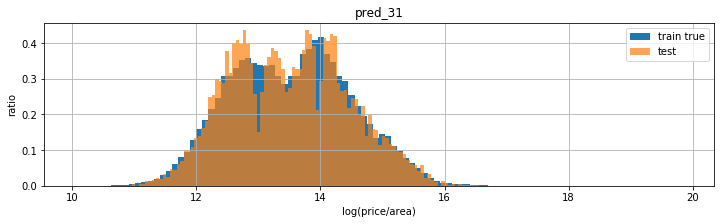

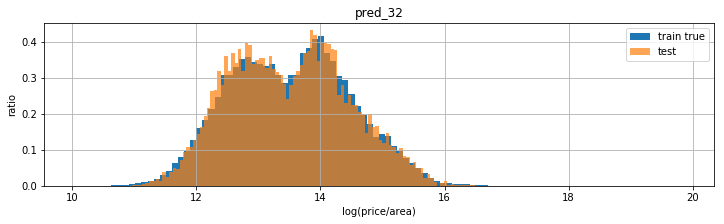

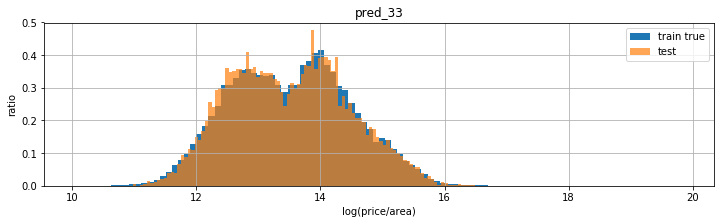

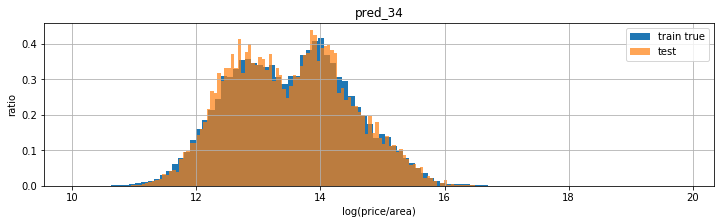

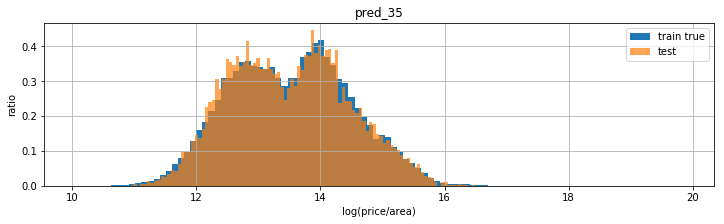

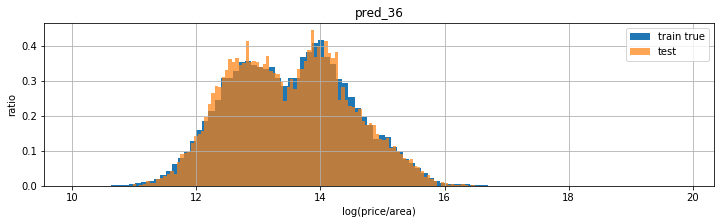

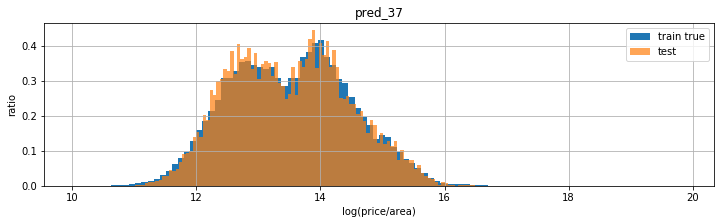

In [104]:
for c in cols_pred:
    plt.figure(figsize=(12, 3))
    plt.hist(df_train['log_parea_total_price'], bins=100, label='train true', normed=True)
    plt.hist(np.log(df_test_fold[c] / df_test_fold['building_area']), bins=100, label='test',
             normed=True, alpha=0.7)
    plt.xlabel('log(price/area)'); plt.ylabel('ratio'); plt.title(c)
    plt.legend(); plt.grid(); plt.show()

In [116]:
df_test_fold_kf = df_kfolds.merge(df_test_kf[['building_id', 'building_area']], on='building_id')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


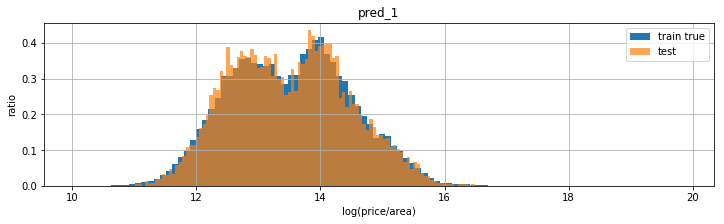

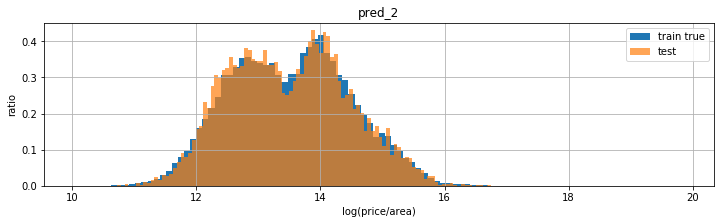

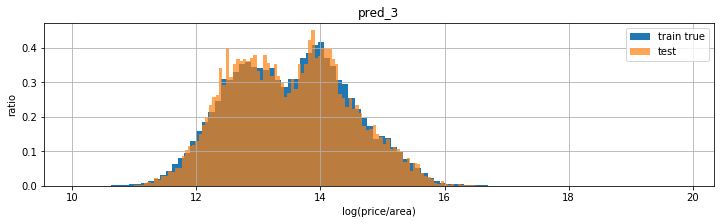

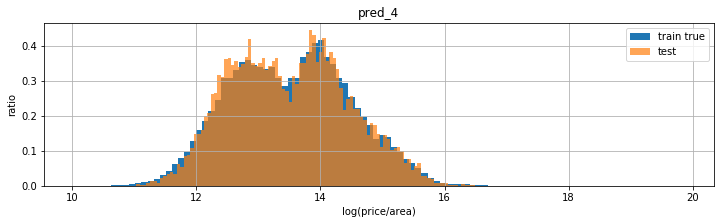

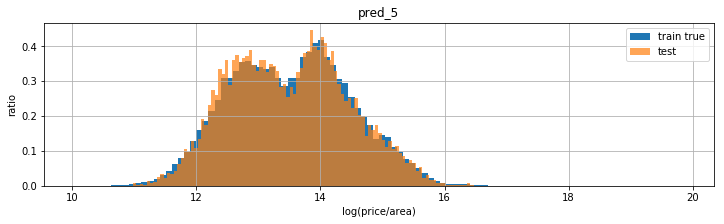

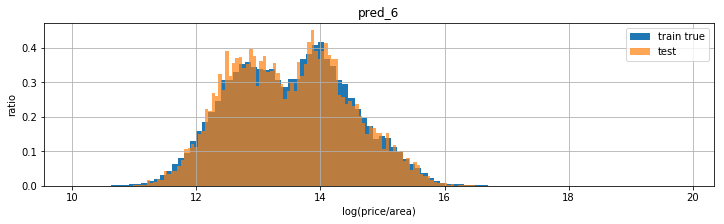

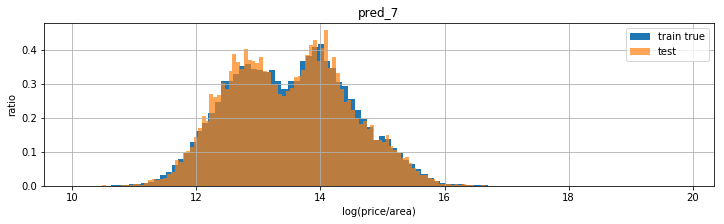

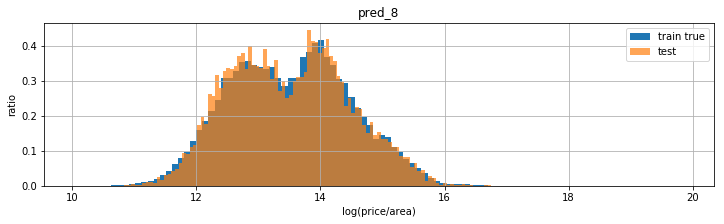

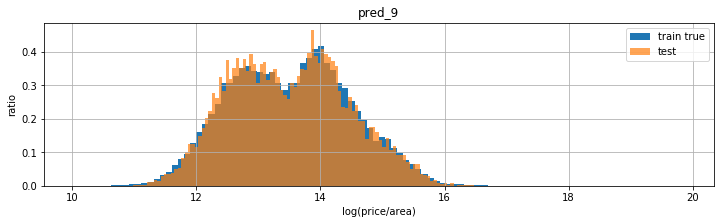

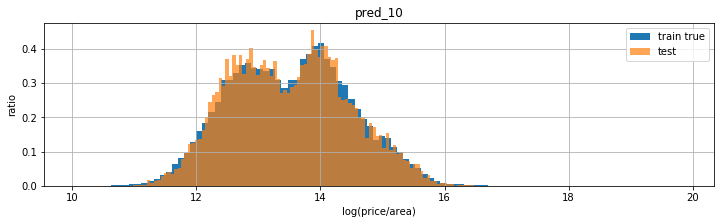

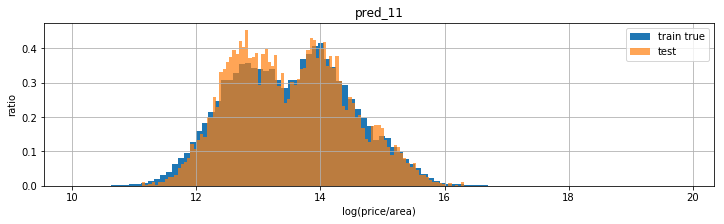

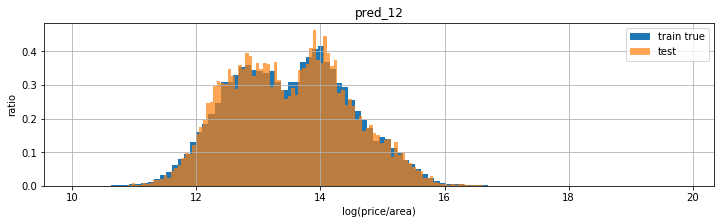

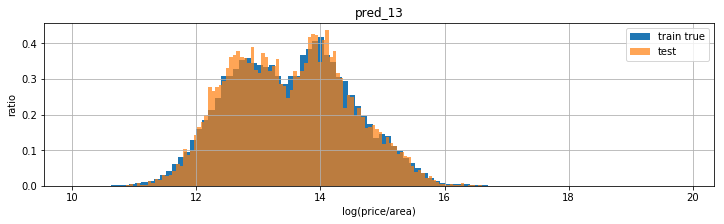

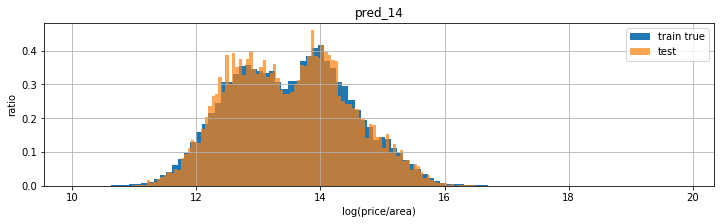

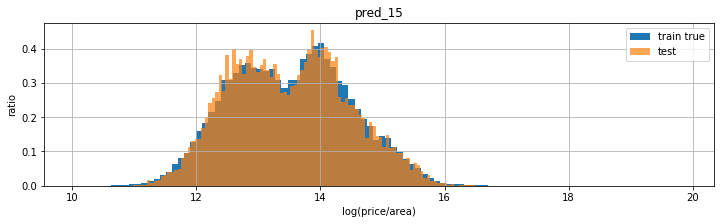

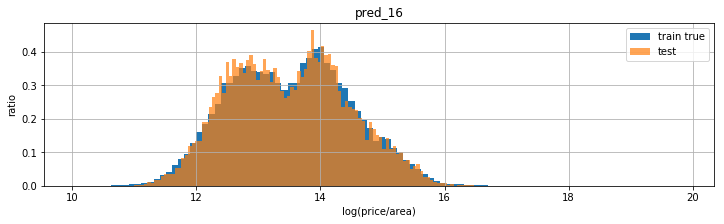

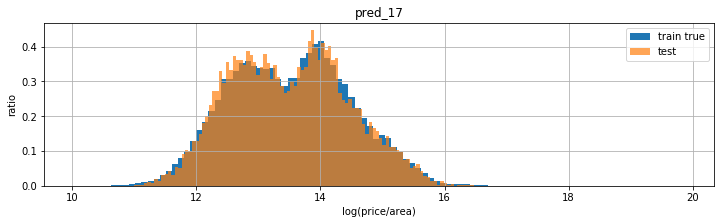

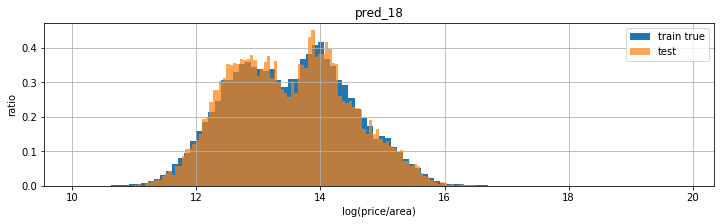

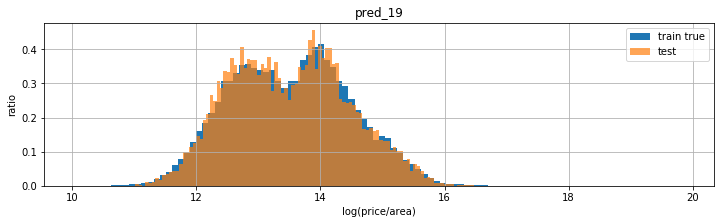

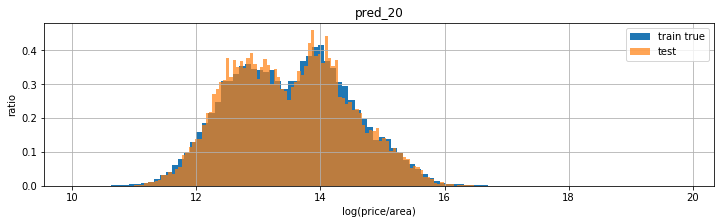

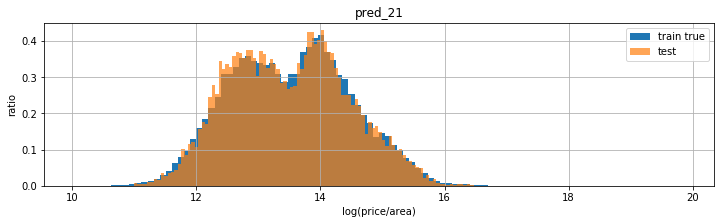

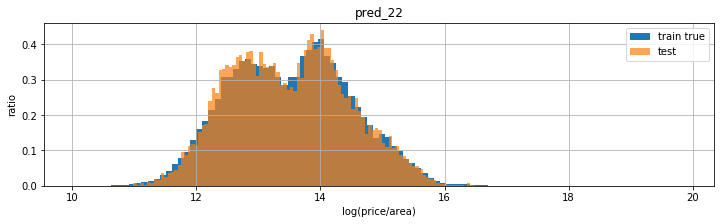

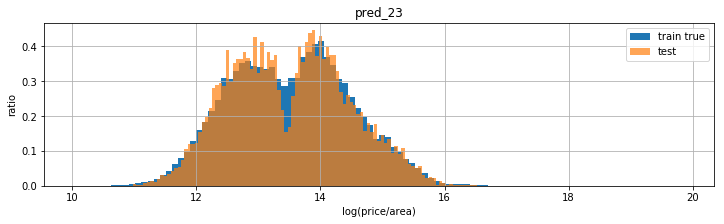

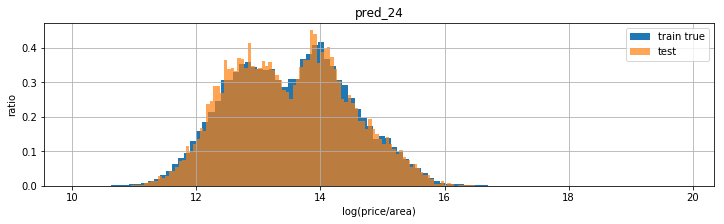

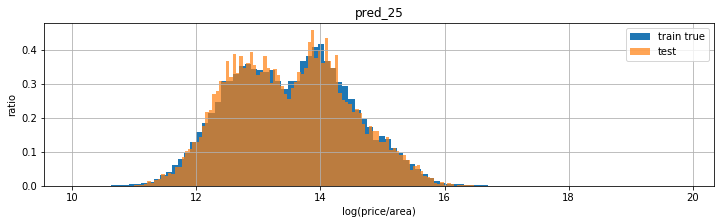

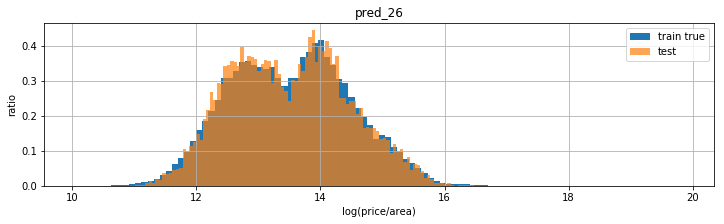

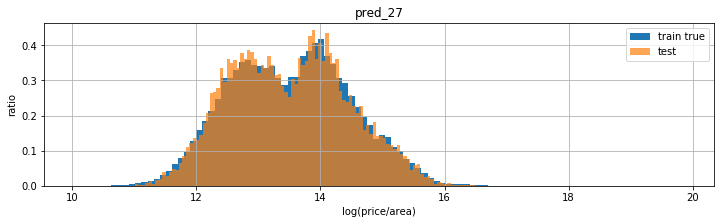

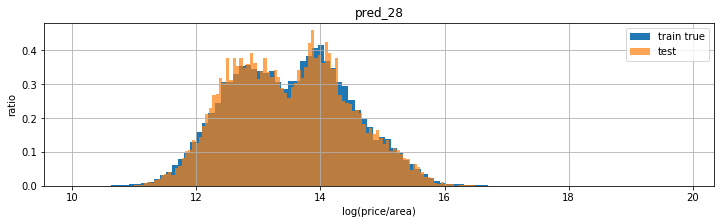

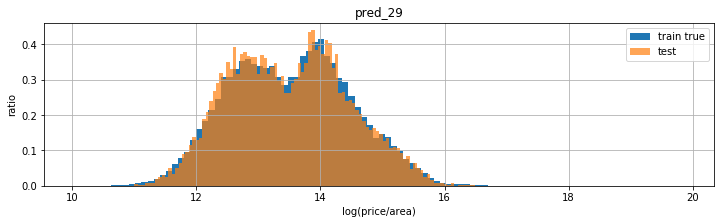

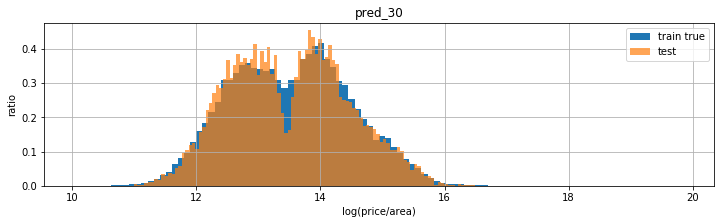

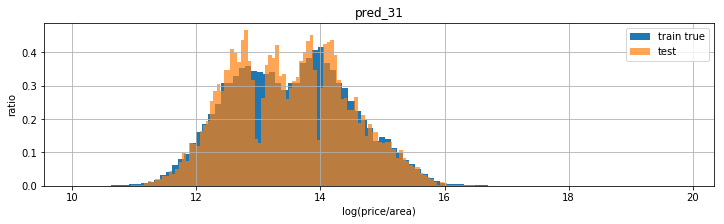

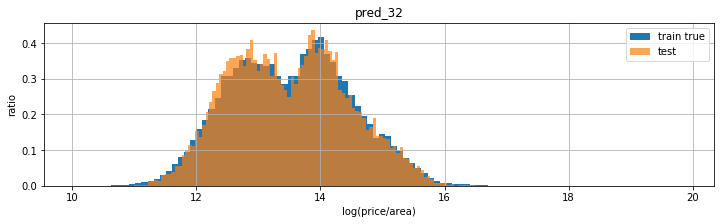

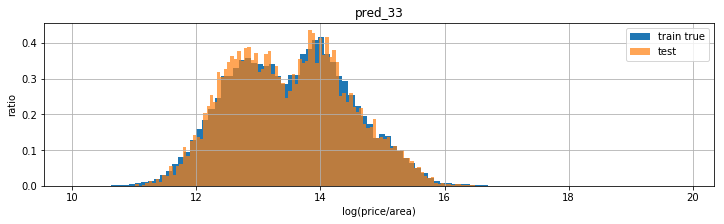

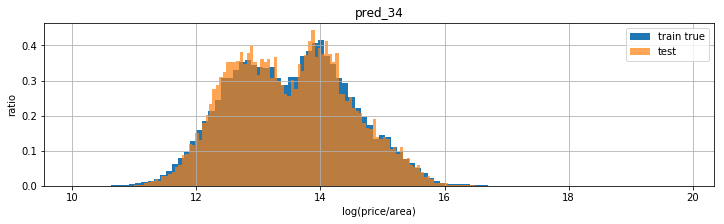

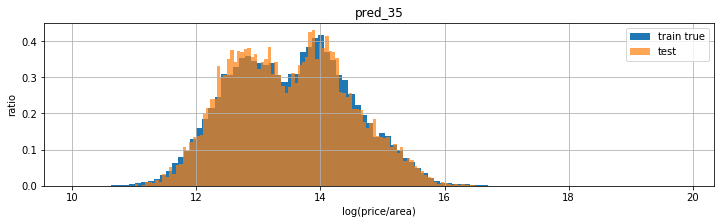

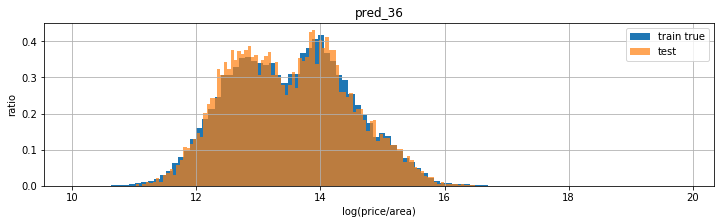

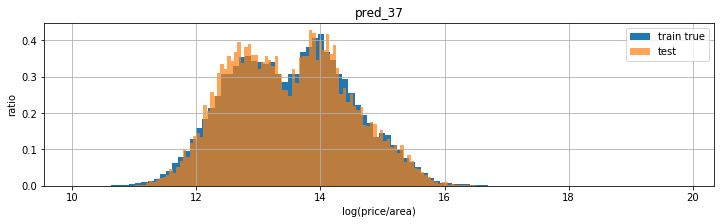

In [117]:
for c in cols_pred:
    plt.figure(figsize=(12, 3))
    plt.hist(df_train['log_parea_total_price'], bins=100, label='train true', normed=True)
    plt.hist(np.log(df_test_fold_kf[c] / df_test_fold_kf['building_area']), bins=100, label='test',
             normed=True, alpha=0.7)
    plt.xlabel('log(price/area)'); plt.ylabel('ratio'); plt.title(c)
    plt.legend(); plt.grid(); plt.show()

In [ ]:
plot_bins = np.arange(cv['log_parea_total_price'].min(), cv['log_parea_total_price'].max(), 0.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


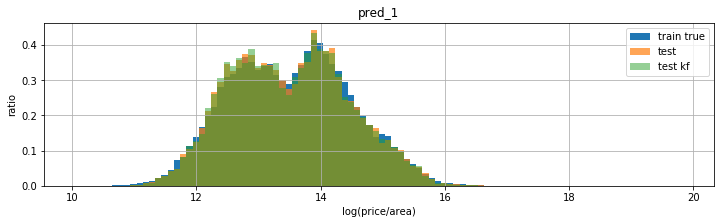

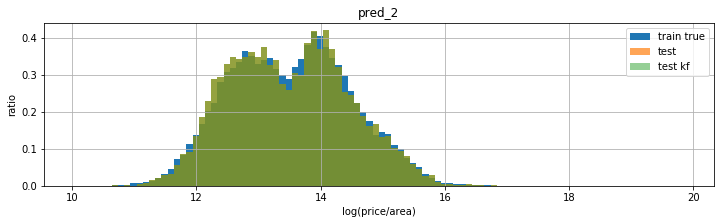

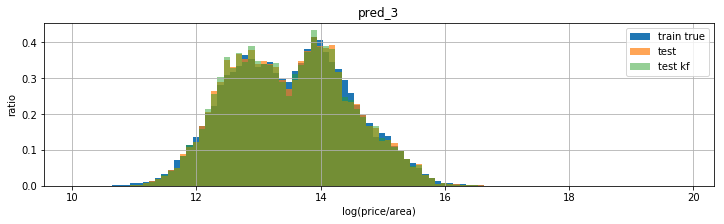

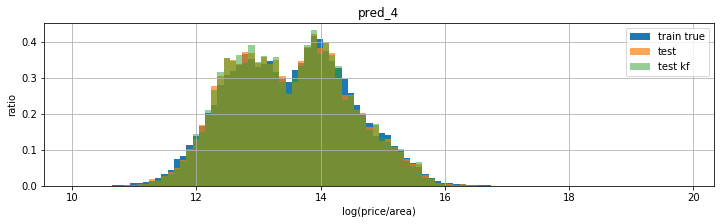

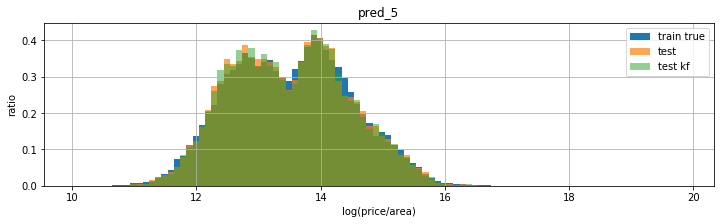

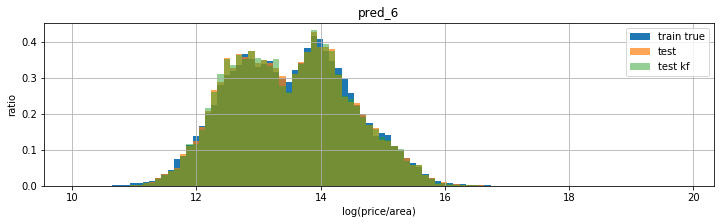

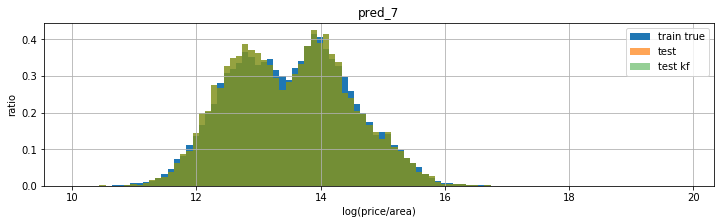

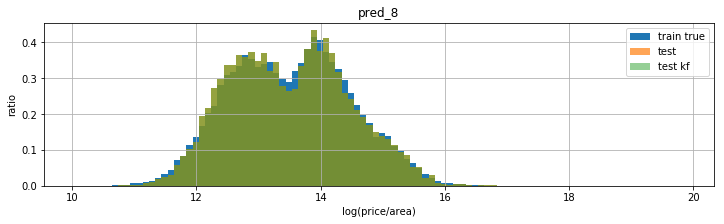

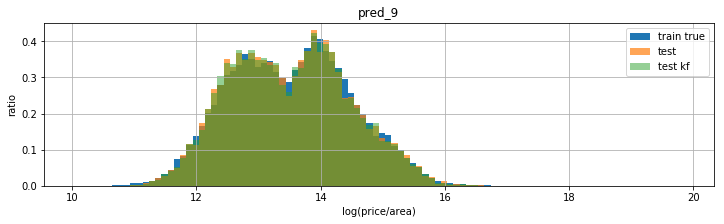

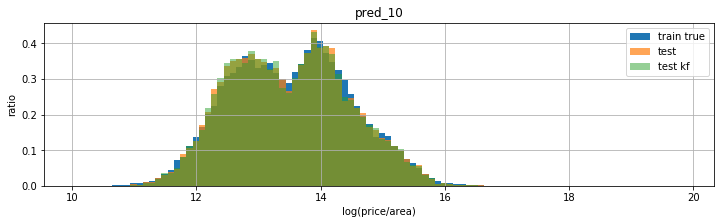

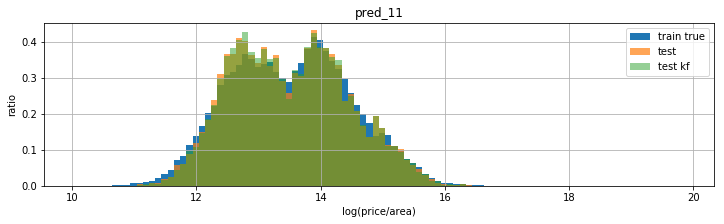

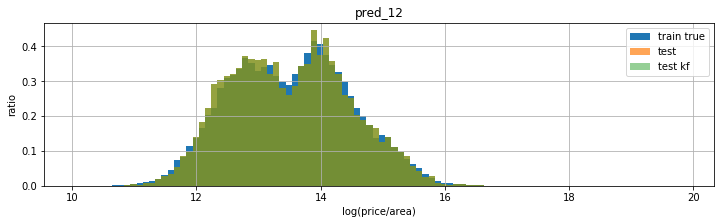

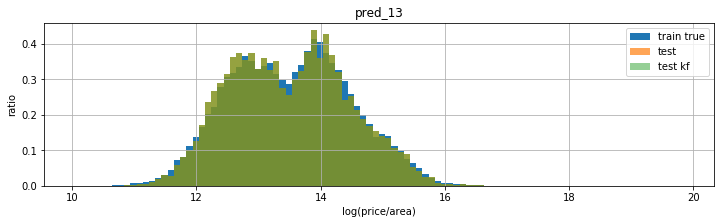

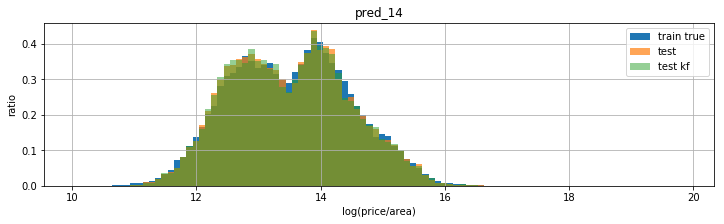

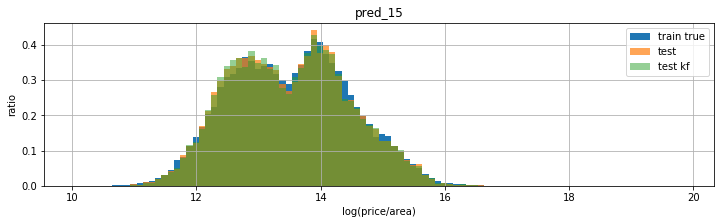

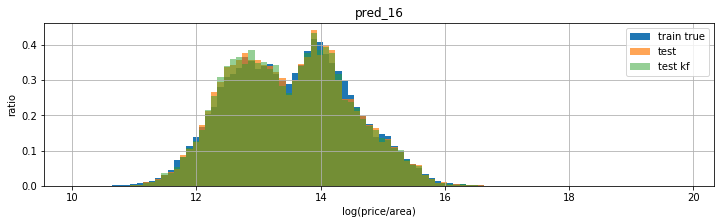

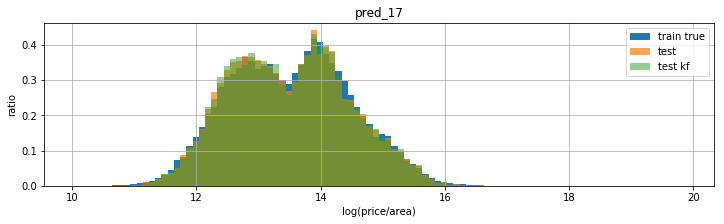

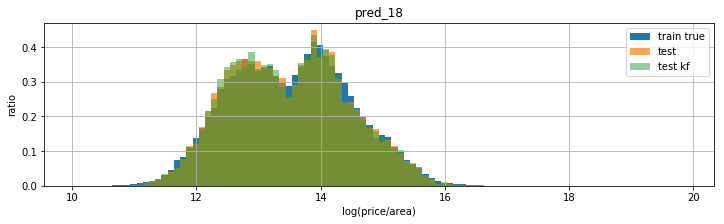

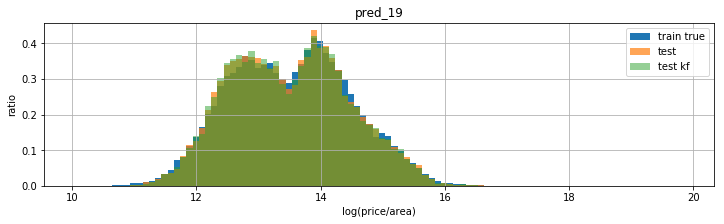

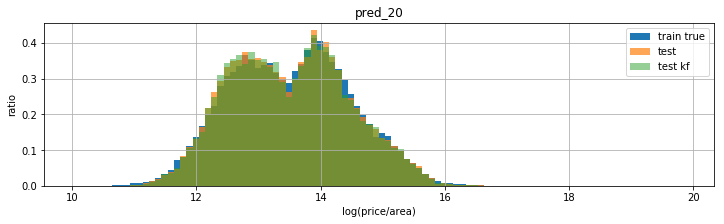

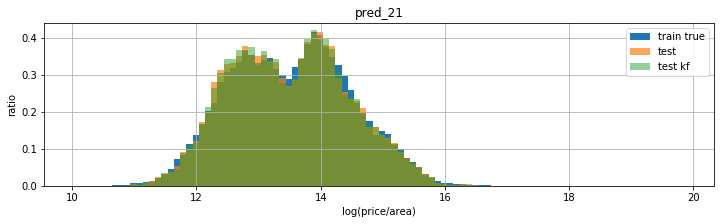

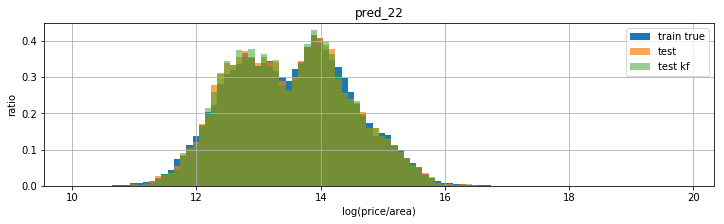

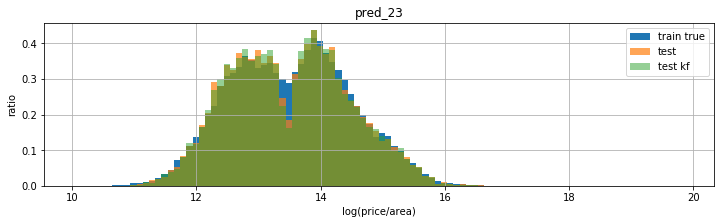

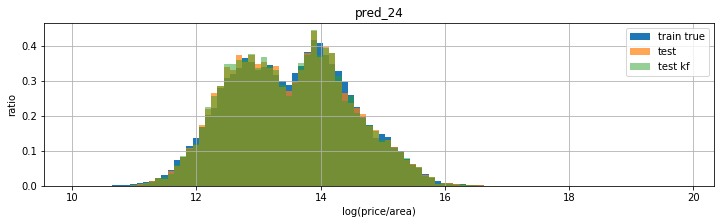

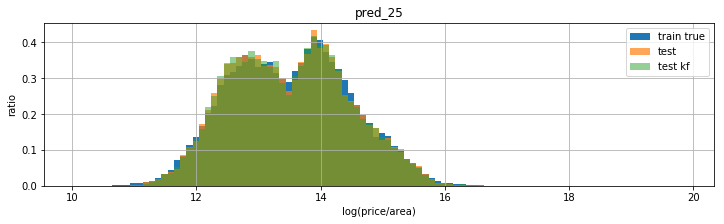

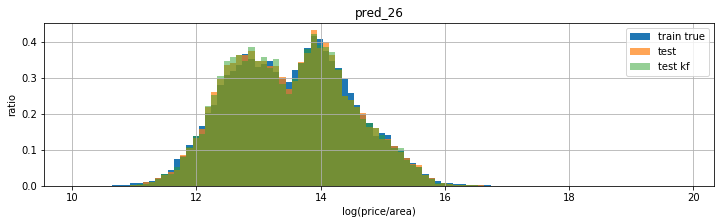

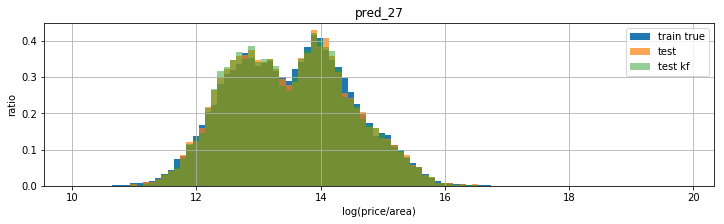

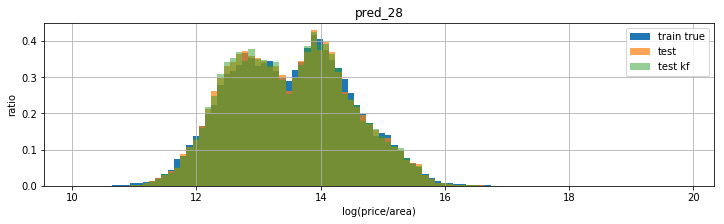

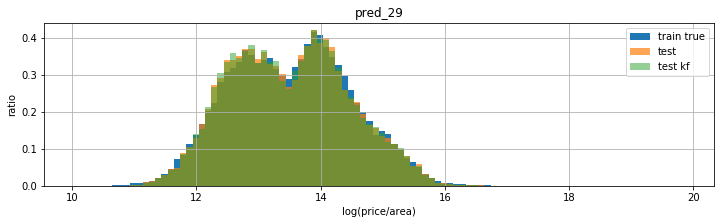

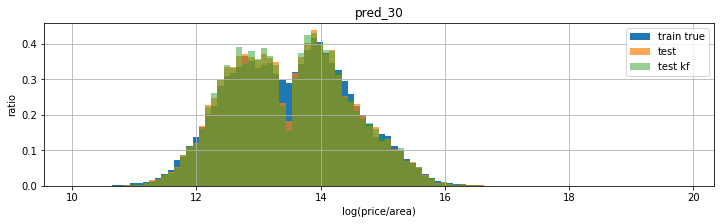

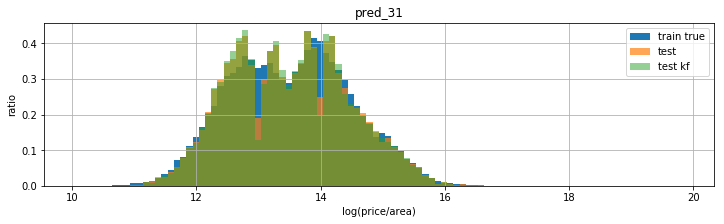

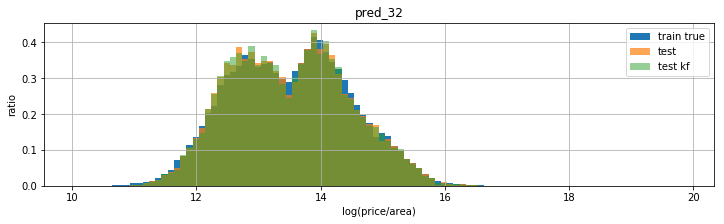

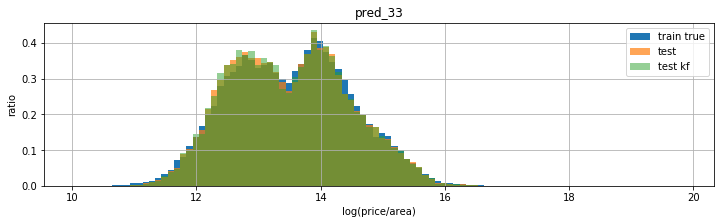

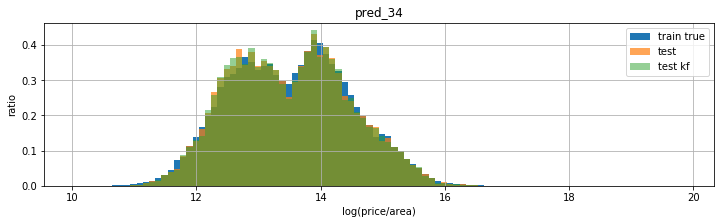

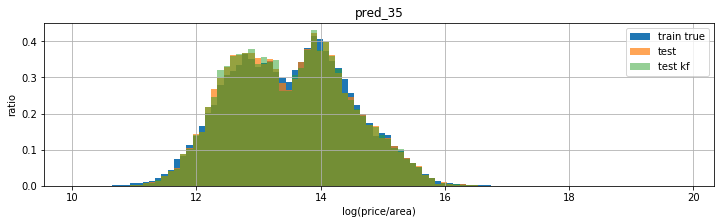

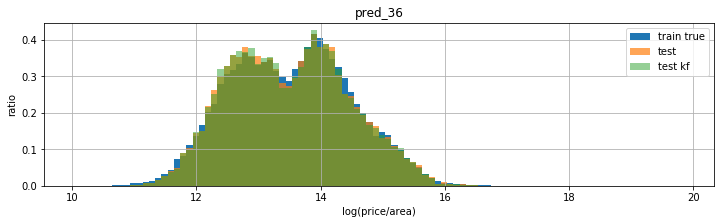

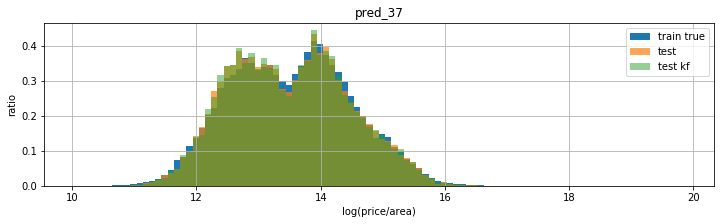

In [121]:
plot_bins = np.arange(df_train['log_parea_total_price'].min(), df_train['log_parea_total_price'].max(), 0.1)
for c in cols_pred:    
    plt.figure(figsize=(12, 3))
    plt.hist(df_train['log_parea_total_price'], bins=plot_bins, label='train true', normed=True)
    plt.hist(np.log(df_test_fold[c] / df_test_fold['building_area']), bins=plot_bins, label='test',
             normed=True, alpha=0.7)
    plt.hist(np.log(df_test_fold_kf[c] / df_test_fold_kf['building_area']), bins=plot_bins, label='test kf',
             normed=True, alpha=0.5)
    plt.xlabel('log(price/area)'); plt.ylabel('ratio'); plt.title(c)
    plt.legend(); plt.grid(); plt.show()